# Business Understanding

It is my job to help Tensa build a deep CNN image classifier for their AI tennis ball machine.

# Data Understanding

I created and gathered all the data used in this project. I used roughly 3,000 images that consisted of a balanced class of forehand and backhand tennis shots. 
The limitations of the dataset was that it was fairly small set of data. The images used only consisted of myself hitting forehands and backhands from one camera angle in one specific location. The data used was useful in this way to build a convolutional neural net image classifier because their was a minimal amount of variance. The neural net was able to learn specific patterns about forehands and backhands with minimal "noise" in the data because of the consistency of the data used.


# Data Preperation

   I started by filming myself in an indoor tennis facility hitting 100 forehands and 100 backhands. I then used an open source editing program called "Shotcut" to edit all of my swings from the start of my swing up until the point of contact with the tennis ball. I then converted these edited video shots into an mp4 format so that they could be extracted into frames.
    I extracted the frames into folders and labeled the frames as either belonging to one of two classes "1" for forehand and "0" for backhand. I constructed an iterator into my pipeline to be able to call on specific "batches" of data. I then scaled my data in the pipeline to make sure that all the images used were the same size.
    I then set up a train, test, split which was 80% for training, 10% for validation, and 10% for testing. I then set up a way to save and load my data after it has been trained into my pipeline so that more data could be input in the future.

In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imghdr
import os
import PIL
import tensorflow as tf
import pickle

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, Adamax

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from glob import glob
import warnings
warnings.filterwarnings('ignore')

import psutil
import time

In [2]:
# Directory containing the video files
video_directory = 'data/forehands/vids'

# Output directory for extracted frames
output_directory = 'data/forehands/frames'

# Function to extract frames from a video file
def extract_frames(video_file, output_dir):
    # Open the video file
    vid = cv2.VideoCapture(video_file)
    if not vid.isOpened():
        print(f"Error: Couldn't open video file '{video_file}'")
        return

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize frame counter
    current_frame = 0

    # Read frames and save them as images
    while True:
        success, frame = vid.read()

        if not success:
            print(f"End of video reached or couldn't read frame from '{video_file}'")
            break

        if frame.shape[0] > 0 and frame.shape[1] > 0:
            # Save the frame as an image
            output_path = os.path.join(output_dir, f'{os.path.splitext(os.path.basename(video_file))[0]}_{current_frame}.jpg')
            cv2.imwrite(output_path, frame)
            current_frame += 1
        else:
            print(f"Error: Invalid frame size in '{video_file}'")

    vid.release()

# Iterate over video files in the directory
for video_file in os.listdir(video_directory):
    if video_file.endswith('.mp4') or video_file.endswith('.avi'):
        video_path = os.path.join(video_directory, video_file)
        extract_frames(video_path, output_directory)

End of video reached or couldn't read frame from 'data/forehands/vids/forehandvids.mp4'


In [3]:
# Defining a data directory
data_dir = 'data'

In [4]:
# Defining image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [5]:
# Checking the contents of my data directory
os.listdir(data_dir)

['forehands', 'backhands']

In [6]:
for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_dir):
        continue  # Skip if not a directory
    for image in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image)
        if not os.path.isfile(image_path):
            print('Skipping non-file:', image_path)
            continue  # Skip if not a file
        try:
            tip = imghdr.what(image_path)  # Get image type directly
            if tip is None or tip not in image_exts:
                print('Image not in ext list or invalid format: {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}: {}'.format(image_path, str(e)))
            # Log the error or handle it appropriately

Skipping non-file: data/forehands/vids
Skipping non-file: data/forehands/frames
Skipping non-file: data/backhands/vids
Skipping non-file: data/backhands/frames


In [7]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image data/forehands/vids
Issue with image data/forehands/frames
Issue with image data/backhands/vids
Issue with image data/backhands/frames


In [8]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [9]:
# you can change batch size here
data = tf.keras.preprocessing.image_dataset_from_directory('data')

Found 2836 files belonging to 2 classes.


In [10]:
# allow acces to generator from the data pipeline
data_iterator = data.as_numpy_iterator()

In [11]:
# allow access to pull a batch of data
batch = data_iterator.next()

In [12]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [13]:
batch[1]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1], dtype=int32)

Forehands = 1
Backhands = 0

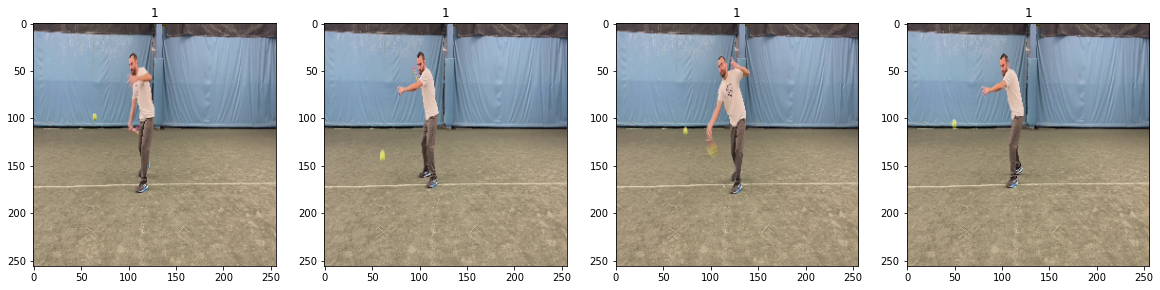

In [14]:
# viewing some  data to see what class my frames belong to
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [15]:
# scaling data in the pipeline
data = data.map(lambda X,y: (X/255, y))

In [16]:

scaled_iterator = data.as_numpy_iterator()

In [17]:
batch = scaled_iterator.next()

In [18]:
# confirming the min is 0
batch[0].min()

0.0

In [19]:
# confirming max is 1
batch[0].max()

1.0

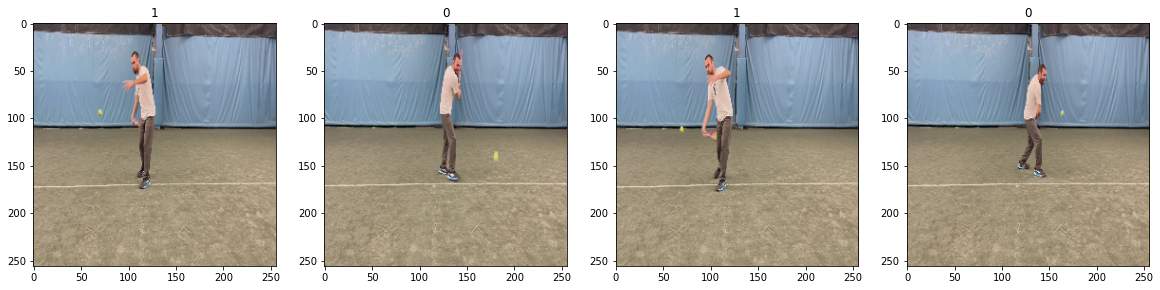

In [20]:
# viewing a batch of data to see what class my frames belong to
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [21]:
# There are 89 batches - currently set to 32 in a batch
len(data)

89

In [22]:
# Shuffle the dataset
data_shuffled = data.shuffle(buffer_size=len(data))

In [23]:
# Splitting data into 80% training, 10% testing, 10% validation
train_size = int(len(data_shuffled)*.8)
val_size = int(len(data_shuffled)*.1)+1
test_size = int(len(data_shuffled)*.1)+1

In [24]:
# 89 batches
train_size+val_size+test_size

89

In [25]:
train = data_shuffled.take(train_size)
val = data_shuffled.skip(train_size).take(val_size)
test = data_shuffled.skip(train_size + val_size).take(test_size)

# Modeling

In [26]:
model = Sequential()

In [27]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

In [30]:
# Creating a log directory that is my logs folder
logdir = 'logs'

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:
# This line of code will initiate training, it will take approx 35 minutes
# Model is opened in the cell below as an h5 file
# Uncomment line 4 and 5 to run and save the model
hist = model.fit(train, epochs=3, validation_data=val, callbacks=[tensorboard_callback])
model.save(os.path.join('models', 'forehandbackhandmodel_4.h5'))

Epoch 1/3
 1/71 [..............................] - ETA: 0s - loss: 0.7139 - accuracy: 0.4062WARNING:tensorflow:From /home/adam/anaconda3/envs/learn-env-1/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
71/71 [==============================] - 89s 1s/step - loss: 0.1415 - accuracy: 0.9562 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 2/3
71/71 [==============================] - 85s 1s/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 2.1306e-04 - val_accuracy: 1.0000
Epoch 3/3
71/71 [==============================] - 103s 1s/step - loss: 1.3218e-04 - accuracy: 1.0000 - val_loss: 1.1194e-04 - val_accuracy: 1.0000


In [33]:
test_loss, test_accuracy = model.evaluate(test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


9/9 [==============================] - 1s 164ms/step - loss: 1.9881e-05 - accuracy: 1.0000
Test Loss: 1.9880759282386862e-05
Test Accuracy: 1.0


In [34]:
val_loss, val_accuracy = model.evaluate(val)
print(f"Val Loss: {test_loss}")
print(f"Val Accuracy: {test_accuracy}")

9/9 [==============================] - 2s 173ms/step - loss: 3.1216e-05 - accuracy: 1.0000
Val Loss: 1.9880759282386862e-05
Val Accuracy: 1.0


In [35]:
# change variable to hist_0
new_model = load_model(os.path.join('models','forehandbackhandmodel_4.h5'))

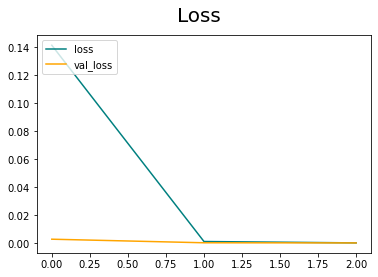

In [36]:
# Visualizing our loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

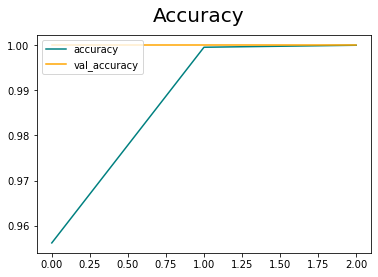

In [37]:
# Visualizing our accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [38]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [39]:
for batch in test.as_numpy_iterator():
    X, y = batch
    y_hat = model.predict(X)
    precision.update_state(y, y_hat)
    recall.update_state(y, y_hat)
    accuracy.update_state(y, y_hat)

In [40]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()},  Accuracy:{accuracy.result().numpy()}')

Precision:1.0, Recall:1.0,  Accuracy:1.0


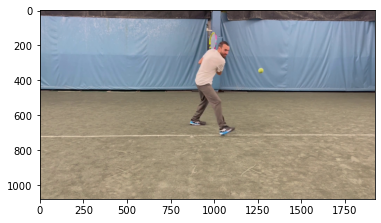

In [41]:
# Performing a test on an image not in our batch
img = cv2.imread('data/backhands/frames/backhandvids_1002.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

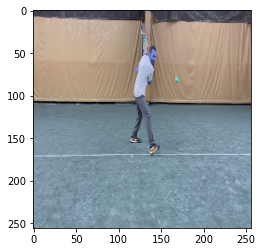

In [42]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [43]:
y_hat = model.predict(np.expand_dims(resize/255, 0))

In [44]:
# It is predicting what our image is 
y_hat

array([[0.00099432]], dtype=float32)

In [45]:
if y_hat > 0.5:
    print(f'Predicted class is Forehand')
else:
    print(f'Predicted class is Backhand')

Predicted class is Backhand


Saving the Model

In [46]:
y_hat_new = new_model.predict(np.expand_dims(resize/255,0))

In [47]:
y_hat_new

array([[0.00099432]], dtype=float32)

In [48]:
if y_hat_new > 0.5:
    print(f'Predicted class is Forehand')
else:
    print(f'Predicted class is Backhand')

Predicted class is Backhand


In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    y_hat_new = new_model.predict(X)
    precision.update_state(y, y_hat_new)
    recall.update_state(y, y_hat_new)
    accuracy.update_state(y, y_hat_new)

In [ ]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()},  Accuracy:{accuracy.result().numpy()}')

# Conclusions

The model showed scores of 100% on accuracy, precision, and recall.

## Limitations

Limited amount of data, data consisted only of myself from one camera angle. The model only learned about two-handed backhand shots and not one-handed backhand shots.

## Recommendations

## Next Steps

Obtain more data on all shots (Forehands, Backhands (one-handed backhands), Overheads, Serves, Volleys). Add more variance of different people hitting shots from different camera angles in different backgrounds. 